In [ ]:
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [ ]:
img_size = 64
n_epochs = 24
batch_size = 64
learning_rate = 0.0002

In [ ]:
transform = transforms.Compose([
                                transforms.Scale(img_size),
                                transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    dset.FashionMNIST('fashion', train=True,
                      download=True, transform=transform),
                      batch_size = batch_size,
                      shuffle=True
)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Extracting fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion/FashionMNIST/raw


Extracting fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion/FashionMNIST/raw


Extracting fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion/FashionMNIST/raw


Extracting fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
def normal_init(m):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(0.0, 0.02)
    m.bias.data.zero_()

In [ ]:
class discriminator_net (nn.Module):
  def __init__(self):
    super(discriminator_net, self).__init__()

    self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
    self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(1024)
    self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

  def weight_init(self):
    for m in self._modules:
      normal_init(self._modules[m])

  def forward(self, input):
    x = F.leaky_relu(self.conv1(input), 0.2)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
    x = F.sigmoid(self.conv5(x))

    return x

In [ ]:
class generator_net(nn.Module):
  def __init__(self):
    super(generator_net, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(100, 1024, 4, 2, 0)
    self.deconv1_bn = nn.BatchNorm2d(1024)
    self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(512)
    self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(256)
    self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(128)
    self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)

  def weight_init(self):
    for m in self._modules:
      normal_init(self._modules[m])

  def forward(self, input):
    x = F.relu(self.deconv1_bn(self.deconv1(input)))
    x = F.relu(self.deconv2_bn(self.deconv2(x)))
    x = F.relu(self.deconv3_bn(self.deconv3(x)))
    x = F.relu(self.deconv4_bn(self.deconv4(x)))
    x = F.tanh(self.deconv5(x))
    
    return x

In [ ]:
def plot_output():
  z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
  z_ = Variable(z_.cuda(), volatile = True)

  generator.eval()
  test_images = generator(z_)
  generator.train()

  grid_size = 5
  fig, ax = plt.subplots(grid_size, grid_size, figsize=(5,5))
  for i, j in itertools.product(range(grid_size), range(grid_size)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
  for k in range(grid_size * grid_size):
    i = k // grid_size
    j = k % grid_size
    ax[i, j].cla()
    ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(),cmap='gray')

  plt.show()

In [ ]:
generator = generator_net()
discriminator = discriminator_net()
generator.weight_init()
discriminator.weight_init()

In [ ]:
generator.cuda()

generator_net(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
discriminator.cuda()

discriminator_net(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [ ]:
BCE_loss = nn.BCELoss()

In [ ]:
beta_1 = 0.5
beta_2 = 0.999

G_optimizer = optim.Adam(generator.parameters(),
                         lr = learning_rate,
                         betas = (beta_1, beta_2))

D_optimizer = optim.Adam(discriminator.parameters(),
                         lr = learning_rate / 2,
                         betas = (beta_1, beta_2))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1 - loss_d: 0.587, loss_g: 4.641


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


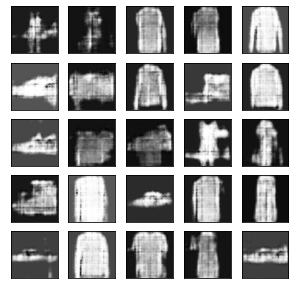

Epoch 2 - loss_d: 0.599, loss_g: 3.624


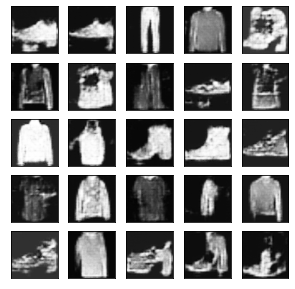

Epoch 3 - loss_d: 0.581, loss_g: 3.696


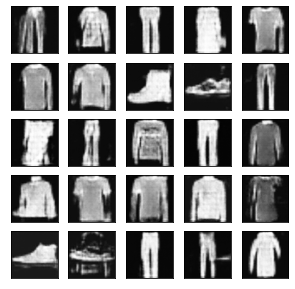

Epoch 4 - loss_d: 0.466, loss_g: 3.876


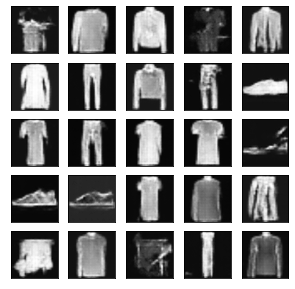

Epoch 5 - loss_d: 0.453, loss_g: 4.199


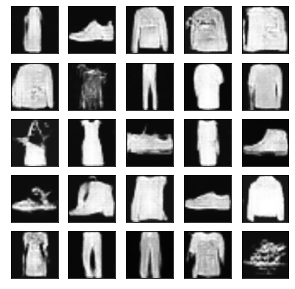

Epoch 6 - loss_d: 0.362, loss_g: 4.406


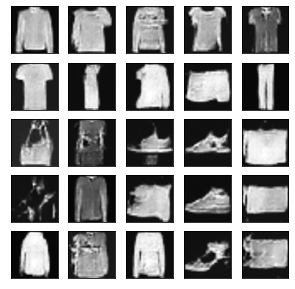

Epoch 7 - loss_d: 0.361, loss_g: 4.520


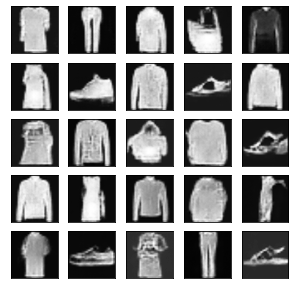

Epoch 8 - loss_d: 0.335, loss_g: 4.661


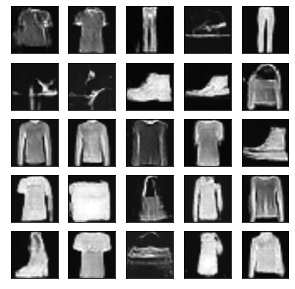

Epoch 9 - loss_d: 0.305, loss_g: 4.764


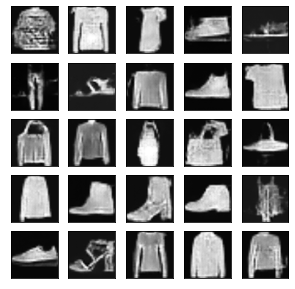

Epoch 10 - loss_d: 0.339, loss_g: 4.769


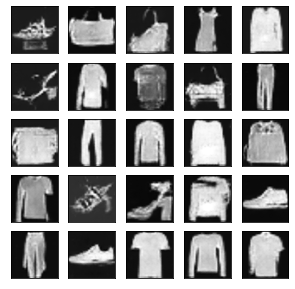

Epoch 11 - loss_d: 0.359, loss_g: 4.542


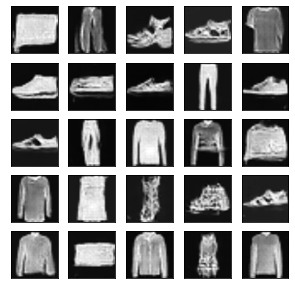

Epoch 12 - loss_d: 0.296, loss_g: 4.772


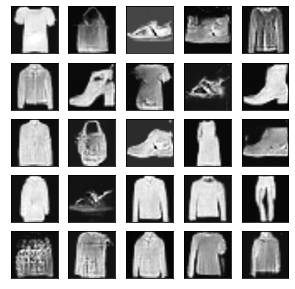

Epoch 13 - loss_d: 0.316, loss_g: 4.611


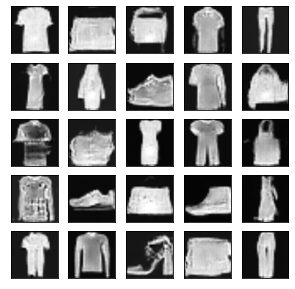

Epoch 14 - loss_d: 0.284, loss_g: 4.889


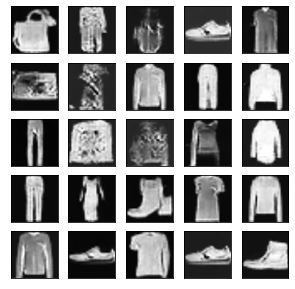

Epoch 15 - loss_d: 0.355, loss_g: 4.602


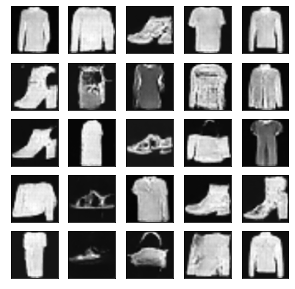

Epoch 16 - loss_d: 0.321, loss_g: 4.847


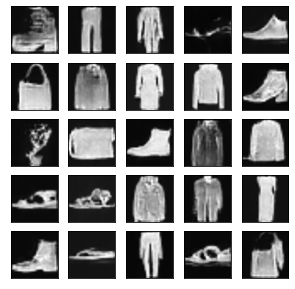

Epoch 17 - loss_d: 0.322, loss_g: 4.674


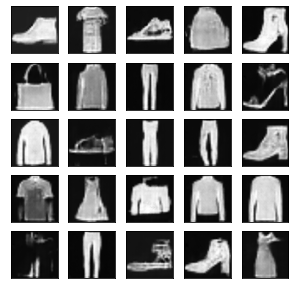

Epoch 18 - loss_d: 0.332, loss_g: 4.682


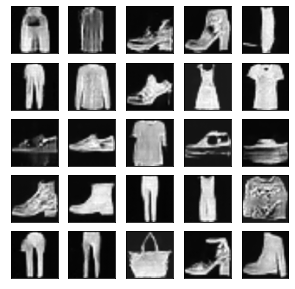

Epoch 19 - loss_d: 0.244, loss_g: 5.061


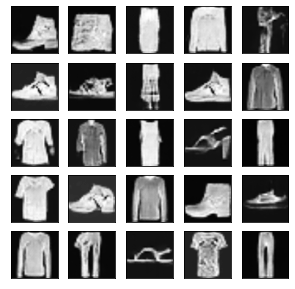

Epoch 20 - loss_d: 0.269, loss_g: 5.229


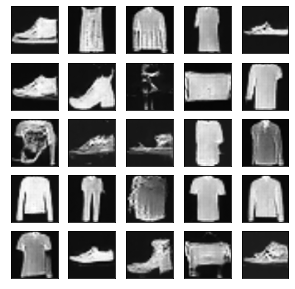

Epoch 21 - loss_d: 0.283, loss_g: 5.028


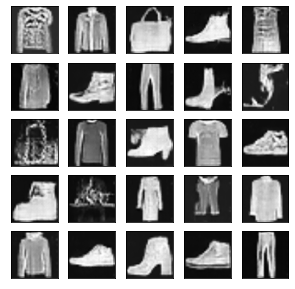

Epoch 22 - loss_d: 0.269, loss_g: 4.923


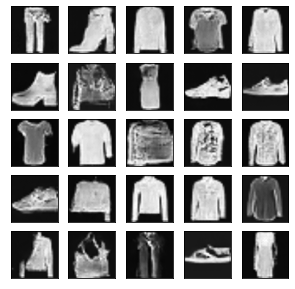

Epoch 23 - loss_d: 0.268, loss_g: 5.213


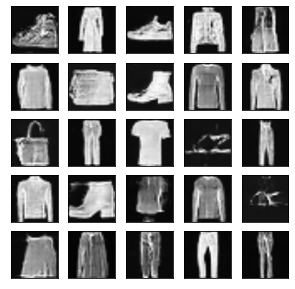

Epoch 24 - loss_d: 0.264, loss_g: 5.063


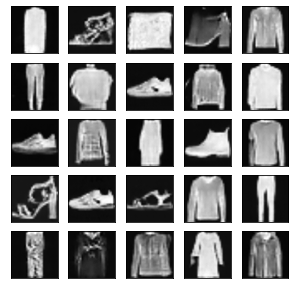

In [ ]:
for epoch in range(n_epochs):

  D_losses = []
  G_losses = []

  for X, _ in train_loader:
    discriminator.zero_grad()
    mini_batch = X.size()[0]

    y_real_ = torch.ones(mini_batch)
    y_fake_ = torch.zeros(mini_batch)

    X = Variable(X.cuda())
    y_real_ = Variable(y_real_.cuda())
    y_fake_ = Variable(y_fake_.cuda())

    D_result = discriminator(X).squeeze()
    D_real_loss = BCE_loss(D_result, y_real_)

    z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda())
    G_result = generator(z_)

    D_result = discriminator(G_result).squeeze()
    D_fake_loss = BCE_loss(D_result, y_fake_)
    D_fake_score = D_result.data.mean()
    D_train_loss = D_real_loss + D_fake_loss

    D_train_loss.backward()
    D_optimizer.step()
    D_losses.append(D_train_loss)

    generator.zero_grad()

    z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda())

    G_result = generator(z_)
    D_result = discriminator(G_result).squeeze()
    G_train_loss = BCE_loss(D_result, y_real_)
    G_train_loss.backward()
    G_optimizer.step()
    G_losses.append(G_train_loss)

  print('Epoch {} - loss_d: {:.3f}, loss_g: {:.3f}'.format((epoch+1),
                                                           torch.mean(torch.FloatTensor(D_losses)),
                                                           torch.mean(torch.FloatTensor(G_losses)),
                                                           ))
  plot_output()